# Sampling from Gaussian Process by Hand

This example is taken from [here](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/).

In the function-space view of gaussian processes (see section 2.2 [here](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)) you look at gaussian processes from the perspective of sampling functions in a similar way as you normally sample random numbers from a distribution, e.g.:
$$f(x)\sim\mathcal{GP}(m(x), k(x, x'))$$
where
$$
\begin{eqnarray}
m(x)&=&\mathbb{E}[f(x)],\\
k(x,x')&=&\mathbb{E}[(f(x)-m(x))(f(x')-m(x'))]
\end{eqnarray}
$$
Usually the mean function $m(x)$ is taken to be zero.

If you look at it from that perspective then it is interesting to draw a few samples and plot them. The purpose of this notebook is to show how that can be done.

## Sampling from a Gaussian Process

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

# https://stackoverflow.com/questions/37149933/how-to-set-max-output-width-in-numpy
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

sns.set()

In [2]:
SEED = 42
np.random.seed(SEED)

For this example we take the SE (squared exponential) kernel (a.k.a. covariance function; have a look [here](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) p. 83). Have a look at the excellent Phd thesis [Automatic Model Construction with Gaussian Processes](https://github.com/duvenaud/phd-thesis/) for an overview of different choice of kernels and their properties.

$$k_{SE}(r)=\sigma^2\cdot e^{-\frac{r^2}{2\ell^2}}$$

In [3]:
class GPCovarianceFunctionSquaredExponential:
    def __init__(self, l, sigma):
        self.l = float(l)
        self.sigma = float(sigma)

    def covariance(self, x1, x2):
        return (self.sigma**2) * np.exp( -0.5 * (np.subtract.outer(x1, x2)**2) / (self.l ** 2))

In [4]:
xpts = np.arange(-3, 3, step=0.01)
k = GPCovarianceFunctionSquaredExponential(l=np.sqrt(0.1), sigma=1)

We will assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

In [5]:
sigma_0 = k.covariance(0, 0)
sigma_0

1.0

(-3.0, 3.0)

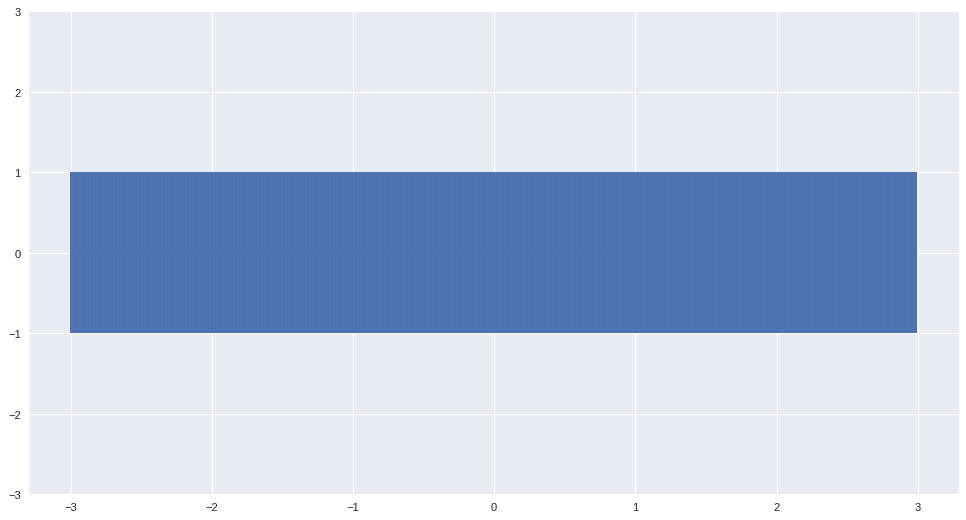

In [6]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
ax.set_ylim(-3.0,3.0)

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [7]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[0.4967141530112327]

In [8]:
sigma_1 = k.covariance(x, x)
sigma_1

array([[ 1.]])

In order to create new function points `y_new` at locations `x_new` after we created a set of initial ones at locations `x` with their corresponding `y` values we have to use the conditional probability as described [here](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf) in equation A.6.

Even while I've taken the example from [here](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/) I will change the notation to fit to the [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/) notation. I will use $y_*$ instead of `y_new`, though.

Given a joint distribution:
$$\left[\begin{matrix}y_*\\ y\end{matrix}\right]\sim\mathcal{N}\left(
\left[\begin{matrix}\bar y_*\\\bar y\end{matrix}\right],
\left[\begin{matrix}A&C\\ C^T&B\end{matrix}\right]
\right)$$

We get the conditional distribution analytically as follows:

$$p(y_*\,|\, X, y, X_*)\sim\mathcal{N}(\bar y_*+CB^{-1}(y-\bar y), A-CB^{-1}C^T)$$

And as we set the mean function $m(x)=0$ this reduces to:

$$p(y_*\,|\, X, y, X_*)\sim\mathcal{N}(CB^{-1}y, A-CB^{-1}C^T)$$

Please also keep in mind that both, $y_*$ and $y$ can be vectors and do not need to be scalars.

In case that $A$, $B$ and $C$ are defined by the covariance function and we only look at predicting one new point $(x_*,y_*)$ we have the following:

$$
\begin{eqnarray}
A&=&k(x_*, x_*)\space\hbox{is a scalar}\\
B&=&k(x_*, x)=k_*\space\hbox{is a vector}\\
C&=&k(X,X)\space\hbox{is a matrix}\\
\end{eqnarray}
$$

See also [here](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf) equations 2.25 and 2.26 for details.

In [9]:
def conditional(x_new, x, y, cov, sigma_n=0):
    total_covariance_function = cov

    A = total_covariance_function.covariance(x_new, x_new)
    C = total_covariance_function.covariance(x_new, x)
    B = total_covariance_function.covariance(x, x) + np.power(sigma_n,2)*np.diag(np.ones(len(x)))

    mu = [np.linalg.inv(B).dot(C.T).T.dot(y).squeeze()]
    sigma = [(A - C.dot(np.linalg.inv(B).dot(C.T))).squeeze()]

    return (mu, sigma)

def predict(x_new, x, y, cov, sigma_n=0):
    l_y_pred, l_sigmas = conditional(x_new, x, y, cov=cov, sigma_n=sigma_n)
    if len(l_sigmas[0].shape) > 1:
        return l_y_pred, [np.diagonal(ls) for ls in l_sigmas]
    else:
        return l_y_pred, l_sigmas

Now we can draw the predicted function value together with the sigmas via the predict method.

In [10]:
y_pred, sigmas         = predict(xpts, x, y, cov=k)

(-3.0, 3.0)

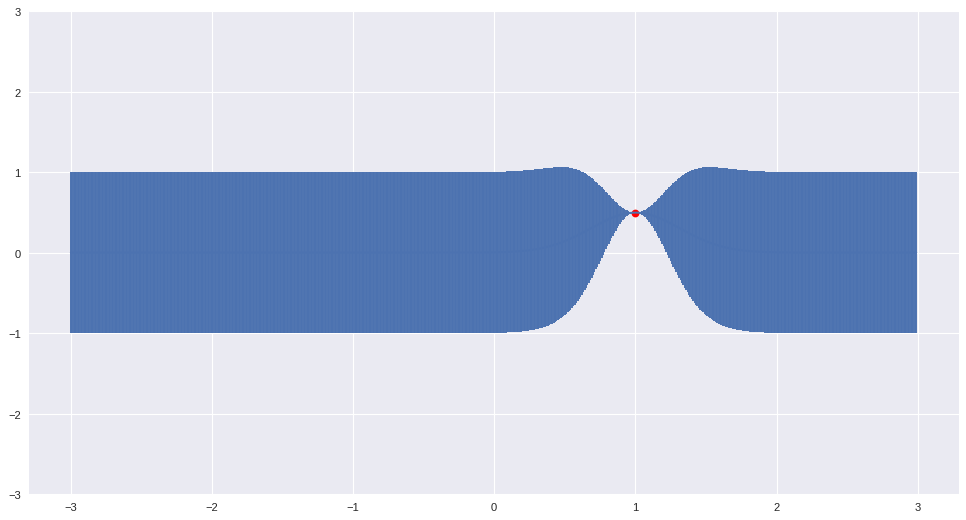

In [11]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.errorbar(xpts, y_pred[0], yerr=sigmas[0], capsize=0)
ax.plot(x, y, "ro")
ax.set_ylim(-3.0,3.0)

Now let's take a second arbitrary location on the $x$-axis, e.g. $-0.7$ and let's repeat the process from before:

In [12]:
new_dp = [-0.7]
m, s = predict(new_dp, x, y, cov=k)
print(m)
print(s)

[array(2.633608839077876e-07)]
[array(0.9999999999997189)]


Drawing a random number with the mean function and standard deviation (sigma):

In [13]:
y2 = np.random.normal(m[0], s[0])
print(m)
print(s)
y2

[array(2.633608839077876e-07)]
[array(0.9999999999997189)]


-0.1382640378102619

Now we add the new x-point to the array of x-values:

In [14]:
# x = [1.0]
x += new_dp
x

[1.0, -0.7]

and the new y-point to the array of y-values:

In [15]:
y.append(y2)
y

[0.4967141530112327, -0.1382640378102619]

And repeat the process from above to predict how the function should look like along the x-axis given the two points we just fixed.

In [16]:
y_pred, sigmas         = predict(xpts, x, y, cov=k)

(-3.0, 3.0)

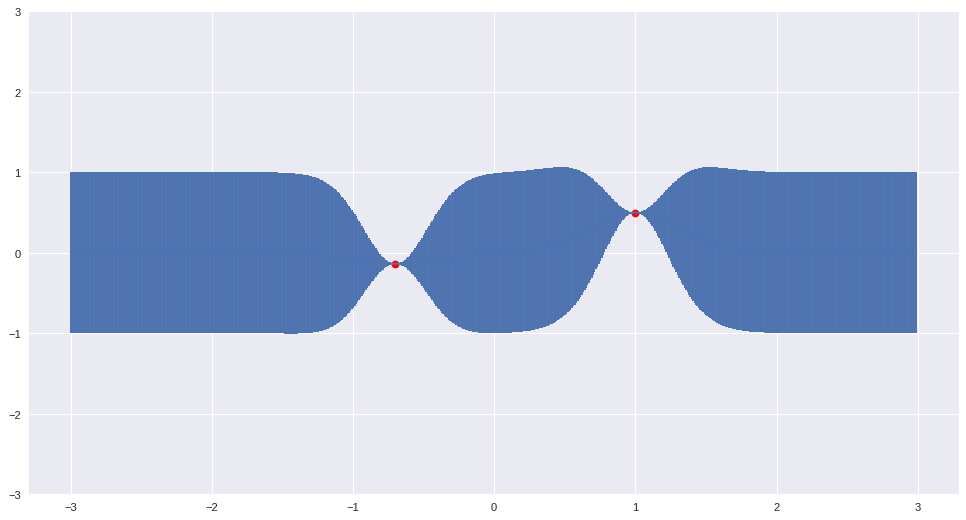

In [17]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.errorbar(xpts, y_pred[0], yerr=sigmas[0], capsize=0)
ax.plot(x, y, "ro")
ax.set_ylim(-3.0,3.0)

At every location where there is a "known" point the standard deviation goes to zero, because the function at this point is not "unknown" or "random" any longer, but fixed and known. This is the effect of using the conditional probability $p(y_*\,|\, X, y, X_*)$ as described above.

Let's draw several values at once rather than going single point by point as we did above:

In [18]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
m, s = conditional(x_more, x, y, cov=k)
print(m[0])
print(s[0])

[ -7.66697664e-06  -5.63595765e-03   4.19316345e-02   2.02471666e-02   6.46090979e-06]
[[  9.99999997e-01   1.65296628e-01  -3.73627090e-07   1.19843900e-12   3.82424663e-16]
 [  1.65296628e-01   9.98338443e-01  -2.74559569e-04   8.80965650e-10   2.81118181e-13]
 [ -3.73627090e-07  -2.74559569e-04   9.92508018e-01  -3.50450933e-03  -1.12241541e-06]
 [  1.19843900e-12   8.80965650e-10  -3.50450933e-03   9.98338443e-01   8.62930563e-02]
 [  3.82424663e-16   2.81118181e-13  -1.12241541e-06   8.62930563e-02   1.00000000e+00]]


In [19]:
y_more = np.random.multivariate_normal(m[0], s[0])
y_more

array([-1.5128756 ,  0.52371713, -0.13952425, -0.93665367, -1.29343995])

In [20]:
x += x_more
y += y_more.tolist()

In [21]:
y_pred, sigmas         = predict(xpts, x, y, cov=k)

(-3.0, 3.0)

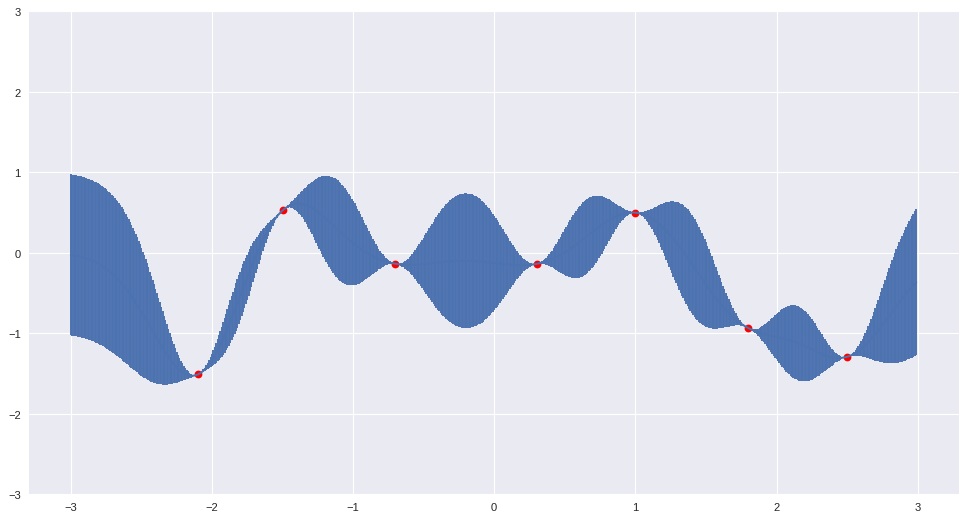

In [22]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.errorbar(xpts, y_pred[0], yerr=sigmas[0], capsize=0)
ax.plot(x, y, "ro")
ax.set_ylim(-3.0,3.0)

You can see how a sample of the function drawn out of the relevant function space (configured via the covariance function) emerges.